In [1]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_1;"  # Replace 'your_table_name' with the actual table name
        df = pd.read_sql(query, connection)
        print("Data read finished")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished


In [3]:
connect_data_path = ['connect_data/pilot_1_2.csv', 'connect_data/pilot_1.csv']
connect_df_1 = pd.read_csv(connect_data_path[0])
connect_df_2 = pd.read_csv(connect_data_path[1])
connect_df = pd.concat([connect_df_1, connect_df_2], axis=0)

connect_ideology_mapping = {
    'Conservative': 2,
    'Liberal': -2,
    'Somewhat Liberal': -1,
    'Somewhat Conservative': 1,
    'Moderate': 0
}

connect_df['Political Ideology'] = connect_df['Political Ideology'].map(connect_ideology_mapping)

df['connect_ideology'] = None
row_index_to_drop = []      # exists in database but not on connect platform
for index, row in df.iterrows():
    id = row['participantId']
    connect_search_result = connect_df[connect_df['ParticipantId'] == id]
    connect_search_result.reset_index(drop=True, inplace=True)
    if len(connect_search_result):
        df.at[index, 'connect_ideology'] = connect_search_result.at[connect_search_result.index.tolist()[0], 'Political Ideology']
    else:
        row_index_to_drop.append(index)
df['connect_ideology'] = df['connect_ideology'].astype(int)
print("Number of rows to drop:", len(row_index_to_drop))
df.head()

Number of rows to drop: 0


,participantId,assignmentId,projectId,attention_passed,total_time,identity_choices,ideologies,ideology_answers,additional_answers,bot_detected,submit_time,reason,connect_ideology
0,012B4E05E38645C787ADD8FC4C076D2F,37a3cfbd-1b7c-48b9-9291-6d34ece07973,633b7bd6-8108-4bdb-b7c7-d62c6ccb2706,1,183.306,"[[14, 0], [4, 2], [16, 5]]","[0, -1, 2]","[{""answers"": [0, 1, 1], ""time_to_answer"": [20....","[[-1.4, -2.2, 1.7], [1.8, 1.9], [1.9, 1.8]]",NaN,NaT,None,0
1,01A875FAA380427BBBEF0A2176E35972,d0cdae81-e2c3-444a-9066-f7a8b9ea03a9,633b7bd6-8108-4bdb-b7c7-d62c6ccb2706,1,240.531,"[[1, 2], [3, 4], [7, 5]]","[0, -2, 1]","[{""answers"": [1, 1, 1], ""time_to_answer"": [15....","[[-3, -1, 1.2], [1.8, 1.8], [1, 1]]",NaN,NaT,None,-2
2,024BA05D98644A2CBD8ECEF3FF884E4A,1cdc2b5a-4282-4290-9125-8d8c9b92bdf2,633b7bd6-8108-4bdb-b7c7-d62c6ccb2706,1,264.582,"[[0, 3], [12, 0], [6, 1]]","[0, -1, 2]","[{""answers"": [1, 1, 0], ""time_to_answer"": [18....","[[-1.9, -1, 3], [2, -3], [2, -3]]",NaN,NaT,None,-2
3,028687F82CEF4E15B1B596ED0A8BD7A1,18f7cc85-ea9f-47e5-8c27-e66b7f87ca1c,9b014bd3-9ef5-449c-9398-611e2fe6cfd6,1,360.875,"[[0, 0], [2, 3], [6, 1]]","[0, -2, 1]","[{""answers"": [0, 1, 0], ""time_to_answer"": [26....","[[-2, 0, 0], [2, 0], [2, 0]]",2.0,2023-08-04 19:30:42,None,-2
4,039E107421874BA791EFF765928429C5,7fdbc85c-216b-4ad7-91df-bb511cc1f080,633b7bd6-8108-4bdb-b7c7-d62c6ccb2706,1,227.305,"[[7, 3], [3, 5], [5, 1]]","[0, -1, 1]","[{""answers"": [1, 1, 1], ""time_to_answer"": [15....","[[0, -1, 2], [1.6, 1], [0.7, -0.4]]",NaN,NaT,None,-1


# Analysis Process
1. Figure out when the abortion statement was changed
2. Mapping: participantId -> number of liberal answers for 6 not extremely stated questions
3. Divide them into 5 ideology groups according to the number
4. Verify each part for the rest 4 extremely stated questions, should observe a relative difference for each group
5. Find the 'common' example for each part

## Do calculations for each participant

In [4]:
df_attention_passed = df[df['attention_passed'] == 1]
data = df[['participantId', 'ideology_answers', 'submit_time', 'additional_answers', 'connect_ideology']]
data.set_index('participantId', inplace=True)
data['ideology_answers'] = data['ideology_answers'].apply(literal_eval)
data['additional_answers'] = data['additional_answers'].apply(literal_eval)

# whether the data is submitted after changing human index or not
change_time = pd.Timestamp('2023-08-08')
def is_after_change(submit_time):
    return not pd.isna(submit_time) and submit_time >= change_time
data['after_change'] = data['submit_time'].apply(is_after_change)
data.drop(['submit_time'], axis=1, inplace=True)
print(data.groupby('after_change').size())

# get reported ideology
def get_human_index(after_change):
    return 1 if after_change else 0

def get_reported_ideology(ideologies, after_change):
    if after_change:
        return ideologies[get_human_index(after_change)]
    else:
        return ideologies[get_human_index(after_change)] / 3 * 2

data['reported_ideology'] = data.apply(lambda row: get_reported_ideology(row['additional_answers'][0], row['after_change']), axis=1)
data.drop(['additional_answers'], axis=1, inplace=True)
data.head()

after_change
False    120
True      79
dtype: int64


,ideology_answers,connect_ideology,after_change,reported_ideology
participantId,,,,
012B4E05E38645C787ADD8FC4C076D2F,"[{'answers': [0, 1, 1], 'time_to_answer': [20....",0,False,-0.933333
01A875FAA380427BBBEF0A2176E35972,"[{'answers': [1, 1, 1], 'time_to_answer': [15....",-2,False,-2.000000
024BA05D98644A2CBD8ECEF3FF884E4A,"[{'answers': [1, 1, 0], 'time_to_answer': [18....",-2,False,-1.266667
028687F82CEF4E15B1B596ED0A8BD7A1,"[{'answers': [0, 1, 0], 'time_to_answer': [26....",-2,False,-1.333333
039E107421874BA791EFF765928429C5,"[{'answers': [1, 1, 1], 'time_to_answer': [15....",-1,False,0.000000


### Explode table for each question

In [5]:
exploded_data = data.explode('ideology_answers')
exploded_data['index'] = exploded_data.apply(lambda row: row['ideology_answers']['idx_of_question'], axis=1)
exploded_data['answer'] = exploded_data.apply(lambda row: row['ideology_answers']['answers'][get_human_index(row['after_change'])], axis=1)
each_question = exploded_data.drop(['ideology_answers'], axis=1)
each_question.head()

,connect_ideology,after_change,reported_ideology,index,answer
participantId,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,8,0
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,0,0
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,3,0
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,6,1
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,4,1


### Get string representation of all answers

In [6]:
def get_ans_str(row, target_index=list(range(10))):
    ret = [0] * len(target_index)
    participant_index = get_human_index(row['after_change'])
    for answer_wrap in row['ideology_answers']:
        index = answer_wrap['idx_of_question']
        if index in target_index:
            ret[target_index.index(index)] = answer_wrap['answers'][participant_index]
    return ret

data['answer_string'] = data.apply(get_ans_str, axis=1)
data.head()

,ideology_answers,connect_ideology,after_change,reported_ideology,answer_string
participantId,,,,,
012B4E05E38645C787ADD8FC4C076D2F,"[{'answers': [0, 1, 1], 'time_to_answer': [20....",0,False,-0.933333,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0]"
01A875FAA380427BBBEF0A2176E35972,"[{'answers': [1, 1, 1], 'time_to_answer': [15....",-2,False,-2.000000,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 1]"
024BA05D98644A2CBD8ECEF3FF884E4A,"[{'answers': [1, 1, 0], 'time_to_answer': [18....",-2,False,-1.266667,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1]"
028687F82CEF4E15B1B596ED0A8BD7A1,"[{'answers': [0, 1, 0], 'time_to_answer': [26....",-2,False,-1.333333,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]"
039E107421874BA791EFF765928429C5,"[{'answers': [1, 1, 1], 'time_to_answer': [15....",-1,False,0.000000,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1]"


In [7]:
from phase_1_statements import phase_1_statements

def is_liberal_answer(row):
    index = row['index']
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    return info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1

def is_extreme_liberal_answer(row):
    info = phase_1_statements[row['index']]
    return info['extreme'] and row['answer'] == 0 and info['left_attitude']

def is_extreme_conservative_answer(row):
    info = phase_1_statements[row['index']]
    return row['index'] != 9 and info['extreme'] and row['answer'] == 0 and not info['left_attitude']

def get_liberal_weight(row):
    index = row['index']
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    if index == 9:
        return 0
    if not info['extreme']:
        if info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1:
            return 1
        else:
            return -1
    else:
        if info['left_attitude']:
            if answer == 0:
                return 2
            else:
                return -0.5
        else:
            if answer == 0:
                return -2
            else:
                return 0.5

each_question['question_liberal_weight'] = each_question.apply(get_liberal_weight, axis=1)
each_question['is_liberal'] = each_question.apply(is_liberal_answer, axis=1)
# each_question['is_extreme_liberal'] = each_question.apply(is_extreme_liberal_answer, axis=1)
# each_question['is_extreme_conservative'] = each_question.apply(is_extreme_conservative_answer, axis=1)
each_question.head()

,connect_ideology,after_change,reported_ideology,index,answer,question_liberal_weight,is_liberal
participantId,,,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,8,0,2.0,True
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,0,0,1.0,True
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,3,0,1.0,True
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,6,1,0.5,True
012B4E05E38645C787ADD8FC4C076D2F,0,False,-0.933333,4,1,1.0,True


### Calculate
1. liberal weight
2. number of liberal answers

In [8]:
num_of_liberal_ans = each_question.groupby('participantId')['is_liberal'].sum()
data['num_of_liberal_ans'] = num_of_liberal_ans
# num_of_extreme_liberal_ans = each_question.groupby('participantId')['is_extreme_liberal'].sum()
# data['num_of_extreme_liberal_ans'] = num_of_extreme_liberal_ans
# num_of_extreme_conservative_ans = each_question.groupby('participantId')['is_extreme_conservative'].sum()
# data['num_of_extreme_conservative_ans'] = num_of_extreme_conservative_ans
# correlation = data['reported_ideology'].corr(data['num_of_liberal_ans'])
# print(f"Correlation between reported ideology and number of liberal answers is {correlation: .3f}")

liberal_weight = each_question.groupby('participantId')['question_liberal_weight'].sum()
data['liberal_weight'] = liberal_weight

data.drop(['ideology_answers', 'after_change'], axis=1, inplace=True)
correlation_reported = data['reported_ideology'].corr(data['liberal_weight'])
correlation_connect = data['connect_ideology'].corr(data['liberal_weight'])
print(f"Correlation between reported ideology and liberal weight is {correlation_reported: .3f}")
print(f"Correlation between connect ideology and liberal weight is {correlation_connect: .3f}")
data.head()

Correlation between reported ideology and liberal weight is -0.714
Correlation between connect ideology and liberal weight is -0.546


,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight
participantId,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,-0.933333,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0]",8,8.5
01A875FAA380427BBBEF0A2176E35972,-2,-2.000000,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 1]",9,8.0
024BA05D98644A2CBD8ECEF3FF884E4A,-2,-1.266667,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1]",9,8.5
028687F82CEF4E15B1B596ED0A8BD7A1,-2,-1.333333,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]",7,4.0
039E107421874BA791EFF765928429C5,-1,0.000000,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1]",7,4.0


### Get weight / count distribution

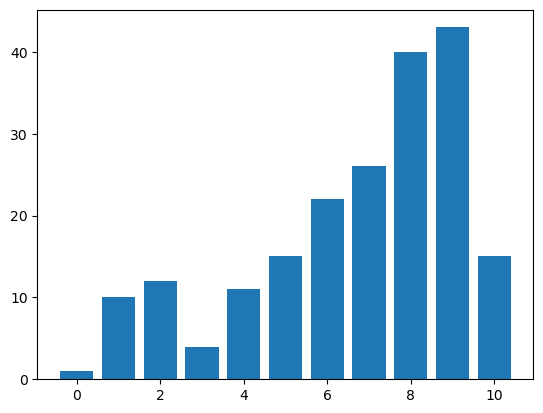

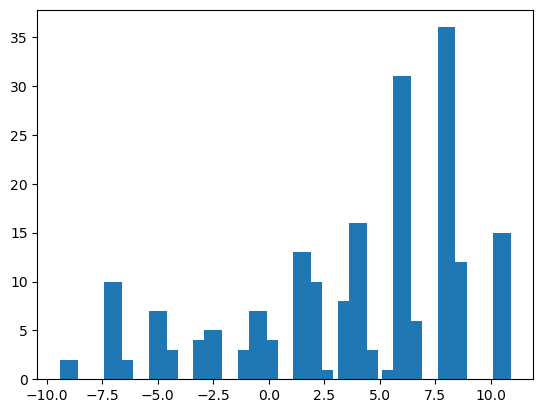

In [9]:
liberal_ans_cnt = data['num_of_liberal_ans'].value_counts()
plt.bar(height=[liberal_ans_cnt[i] for i in range(11)], x=list(range(11)))
plt.show()

liberal_weight_counts = data['liberal_weight'].value_counts()
liberal_weight_index_list = sorted(liberal_weight_counts.index.tolist())
plt.bar(height=[liberal_weight_counts[index] for index in liberal_weight_index_list], x=liberal_weight_index_list)
plt.show()

## Group participants according to a given benchmark

In [10]:
chosen_ranges = [(0, 0.1), (0.3, 0.4), (0.6, 0.7), (0.9, 0.999)]
num = len(data)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight
participantId,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,-0.933333,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0]",8,8.5
01A875FAA380427BBBEF0A2176E35972,-2,-2.000000,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 1]",9,8.0
024BA05D98644A2CBD8ECEF3FF884E4A,-2,-1.266667,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1]",9,8.5
028687F82CEF4E15B1B596ED0A8BD7A1,-2,-1.333333,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]",7,4.0
039E107421874BA791EFF765928429C5,-1,0.000000,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1]",7,4.0


### 1. Use number of liberal answers

In [11]:
num_of_liberal_ans = sorted(data['num_of_liberal_ans'].tolist())
for each_range in chosen_ranges:
    print(f"For range {each_range}, start: {num_of_liberal_ans[int(num * each_range[0])]}, end: {num_of_liberal_ans[int(num * each_range[1])]}")

For range (0, 0.1), start: 0, end: 2
For range (0.3, 0.4), start: 6, end: 7
For range (0.6, 0.7), start: 8, end: 8
For range (0.9, 0.999), start: 9, end: 10


In [19]:
def get_ideology_from_num(num):
    if num == 0 or num == 1:
        return -2
    elif num == 4:
        return -1
    elif num == 8:
        return 1
    elif num == 10:
        return 2
    else:
        return 0

data['ideology_from_num'] = data['num_of_liberal_ans'].map(get_ideology_from_num)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight,ideology_from_num,ideology_from_weight
participantId,,,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,-0.933333,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0]",8,8.5,1,1
01A875FAA380427BBBEF0A2176E35972,-2,-2.000000,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 1]",9,8.0,0,0
024BA05D98644A2CBD8ECEF3FF884E4A,-2,-1.266667,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1]",9,8.5,0,1
028687F82CEF4E15B1B596ED0A8BD7A1,-2,-1.333333,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]",7,4.0,0,-1
039E107421874BA791EFF765928429C5,-1,0.000000,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1]",7,4.0,0,-1


### 2. Use calculated liberal weight

In [13]:
liberal_weight = sorted(data['liberal_weight'].tolist())
for each_range in chosen_ranges:
    print(f"For range {each_range}, start: {liberal_weight[int(num * each_range[0])]}, end: {liberal_weight[int(num * each_range[1])]}")

For range (0, 0.1), start: -9.0, end: -5.0
For range (0.3, 0.4), start: 1.5, end: 4.0
For range (0.6, 0.7), start: 6.0, end: 8.0
For range (0.9, 0.999), start: 8.5, end: 10.5


In [14]:
def get_ideology_from_weight(weight):
    if weight >= -9 and weight <= -5:
        return -2
    elif weight >= 1.5 and weight <= 4:
        return -1
    elif weight >= 8.5 and weight <= 9.5:
        return 1
    elif weight >= 10 and weight <= 10.5:
        return 2
    else:
        return 0

data['ideology_from_weight'] = data['liberal_weight'].map(get_ideology_from_weight)
data.head()

,connect_ideology,reported_ideology,answer_string,num_of_liberal_ans,liberal_weight,ideology_from_num,ideology_from_weight
participantId,,,,,,,
012B4E05E38645C787ADD8FC4C076D2F,0,-0.933333,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0]",8,8.5,1,1
01A875FAA380427BBBEF0A2176E35972,-2,-2.000000,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 1]",9,8.0,2,0
024BA05D98644A2CBD8ECEF3FF884E4A,-2,-1.266667,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 1]",9,8.5,2,1
028687F82CEF4E15B1B596ED0A8BD7A1,-2,-1.333333,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]",7,4.0,-1,-1
039E107421874BA791EFF765928429C5,-1,0.000000,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1]",7,4.0,-1,-1


## Calculate average answer for each question in each group

In [21]:
each_question['ideology_from_num'] = data['ideology_from_num']
for question_ideology in [-2, -1, 1, 2]:
    print(f"For ideology {question_ideology}")
    each_question_given_ideology = each_question[each_question['ideology_from_num'] == question_ideology]
    print(each_question_given_ideology.groupby('index')['answer'].mean().tolist())

For ideology -2
[0.8181818181818182, 0.9090909090909091, 0.18181818181818182, 1.0, 0.09090909090909091, 0.8181818181818182, 0.09090909090909091, 1.0, 1.0, 0.09090909090909091]
For ideology -1
[0.45454545454545453, 0.36363636363636365, 0.5454545454545454, 0.9090909090909091, 0.5454545454545454, 0.7272727272727273, 0.18181818181818182, 1.0, 0.36363636363636365, 0.5454545454545454]
For ideology 1
[0.25, 0.05, 0.775, 0.275, 0.95, 0.225, 0.85, 0.6, 0.05, 0.875]
For ideology 2
[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]


In [16]:
each_question['ideology_from_weight'] = data['ideology_from_weight']
for question_ideology in [-2, -1, 1, 2]:
    print(f"For ideology {question_ideology}")
    each_question_given_ideology = each_question[each_question['ideology_from_weight'] == question_ideology]
    print(each_question_given_ideology.groupby('index')['answer'].mean())

For ideology -2
index
0    0.809524
1    0.904762
2    0.285714
3    1.000000
4    0.238095
5    0.666667
6    0.095238
7    1.000000
8    1.000000
9    0.238095
Name: answer, dtype: float64
For ideology -1
index
0    0.250000
1    0.291667
2    0.562500
3    0.645833
4    0.750000
5    0.208333
6    0.645833
7    0.875000
8    0.187500
9    0.791667
Name: answer, dtype: float64
For ideology 1
index
0    0.250000
1    0.166667
2    0.750000
3    0.000000
4    1.000000
5    0.333333
6    1.000000
7    0.000000
8    0.000000
9    0.666667
Name: answer, dtype: float64
For ideology 2
index
0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
5    0.0
6    1.0
7    0.0
8    0.0
9    1.0
Name: answer, dtype: float64


In [17]:
each_question_somewhat_conservative = each_question[each_question['ideology_from_weight'] == -1]
average_answer_somewhat_conservative = each_question_somewhat_conservative.groupby('index')['answer'].mean()

each_question_somewhat_liberal = each_question[each_question['ideology_from_weight'] == 1]
average_answer_somewhat_liberal = each_question_somewhat_liberal.groupby('index')['answer'].mean()
sum(abs(average_answer_somewhat_conservative - average_answer_somewhat_liberal))

2.875

In [18]:
each_question_somewhat_conservative = each_question[each_question['ideology_from_num'] == -1]
average_answer_somewhat_conservative = each_question_somewhat_conservative.groupby('index')['answer'].mean()

each_question_somewhat_liberal = each_question[each_question['ideology_from_num'] == 1]
average_answer_somewhat_liberal = each_question_somewhat_liberal.groupby('index')['answer'].mean()
sum(abs(average_answer_somewhat_conservative - average_answer_somewhat_liberal))

1.5